In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlflow.genai import Scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, mean_absolute_error, root_mean_squared_error, r2_score

# Cluster Result Prediction

In [14]:
data = pd.read_csv("../data/processed/insurance_clustered.csv")
data

,age,sex,bmi,children,smoker,region,charges,Cluster
0,19.0,female,27.900,0.0,yes,southwest,16884.92400,1
1,18.0,male,33.770,1.0,no,southeast,1725.55230,1
2,28.0,male,33.000,3.0,no,southeast,4449.46200,1
3,33.0,male,22.705,0.0,no,northwest,21984.47061,0
4,32.0,male,28.880,0.0,no,northwest,3866.85520,0
...,...,...,...,...,...,...,...,...
1332,50.0,male,30.970,3.0,no,northwest,10600.54830,0
1333,18.0,female,31.920,0.0,no,northeast,2205.98080,0
1334,18.0,female,36.850,0.0,no,southeast,1629.83350,1
1335,21.0,female,25.800,0.0,no,southwest,2007.94500,1


In [15]:
numerical_features = data.select_dtypes(include=[np.number]).columns.drop('Cluster', errors='ignore')
categorical_features = data.select_dtypes(include=["object"]).columns


In [16]:
le = LabelEncoder()
for col in categorical_features:
    data[col] = le.fit_transform(data[col])
data

,age,sex,bmi,children,smoker,region,charges,Cluster
0,19.0,0,27.900,0.0,1,3,16884.92400,1
1,18.0,1,33.770,1.0,0,2,1725.55230,1
2,28.0,1,33.000,3.0,0,2,4449.46200,1
3,33.0,1,22.705,0.0,0,1,21984.47061,0
4,32.0,1,28.880,0.0,0,1,3866.85520,0
...,...,...,...,...,...,...,...,...
1332,50.0,1,30.970,3.0,0,1,10600.54830,0
1333,18.0,0,31.920,0.0,0,0,2205.98080,0
1334,18.0,0,36.850,0.0,0,2,1629.83350,1
1335,21.0,0,25.800,0.0,0,3,2007.94500,1


In [17]:
X = data.drop('Cluster', axis=1)
y = data['Cluster']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training Data shape: {xtrain.shape}")
print(f"Testing Data shape: {xtest.shape}")

Training Data shape: (1069, 7)
Testing Data shape: (268, 7)


In [18]:
scaler = MinMaxScaler()
xtrain[numerical_features] = scaler.fit_transform(xtrain[numerical_features])
xtest[numerical_features] = scaler.transform(xtest[numerical_features])

In [20]:
rf = RandomForestClassifier()
rf.fit(xtrain, ytrain)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
xgb = XGBClassifier()
xgb.fit(xtrain, ytrain)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [23]:
def evaluate_model(model, xtest, ytest):
    ypred = model.predict(xtest)
    cm = confusion_matrix(ytest, ypred)
    tn, fp, fn, tp = cm.ravel()
    results = {
        'Confusion Matrix': cm,
        'True Positive': tp,
        'True Negative': tn,
        'False Positive': fp,
        'False Negative': fn,
        'Accuracy': accuracy_score(ytest, ypred),
        'Precision': precision_score(ytest, ypred),
        'F1 Score': f1_score(ytest, ypred),
        'Recall': recall_score(ytest, ypred)
    }
    return results

results = {
    "Random Forest": evaluate_model(rf, xtest, ytest),
    "XGBoost": evaluate_model(xgb, xtest, ytest)
}

summary = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'F1 Score', 'Recall'])
row = []
for model, result in results.items():
    row.append({
        'Model': model,
        'Accuracy': f"{result['Accuracy']:.2f}",
        'Precision': f"{result['Precision']:.2f}",
        'F1 Score': f"{result['F1 Score']:.2f}",
        'Recall': f"{result['Recall']:.2f}"
    })
summary = pd.DataFrame(row)
summary

,Model,Accuracy,Precision,F1 Score,Recall
0,Random Forest,1.00,1.00,1.00,1.00
1,XGBoost,1.00,1.00,1.00,1.00


# Charges Prediction

In [24]:
data = pd.read_csv("../data/processed/insurance_clustered.csv")
data

,age,sex,bmi,children,smoker,region,charges,Cluster
0,19.0,female,27.900,0.0,yes,southwest,16884.92400,1
1,18.0,male,33.770,1.0,no,southeast,1725.55230,1
2,28.0,male,33.000,3.0,no,southeast,4449.46200,1
3,33.0,male,22.705,0.0,no,northwest,21984.47061,0
4,32.0,male,28.880,0.0,no,northwest,3866.85520,0
...,...,...,...,...,...,...,...,...
1332,50.0,male,30.970,3.0,no,northwest,10600.54830,0
1333,18.0,female,31.920,0.0,no,northeast,2205.98080,0
1334,18.0,female,36.850,0.0,no,southeast,1629.83350,1
1335,21.0,female,25.800,0.0,no,southwest,2007.94500,1


In [30]:
numerical_features = data.select_dtypes(include=[np.number]).columns.drop('charges', errors='ignore')
categorical_features = data.select_dtypes(include=["object"]).columns

In [31]:
le = LabelEncoder()
for col in categorical_features:
    data[col] = le.fit_transform(data[col])
data

,age,sex,bmi,children,smoker,region,charges,Cluster
0,19.0,0,27.900,0.0,1,3,16884.92400,1
1,18.0,1,33.770,1.0,0,2,1725.55230,1
2,28.0,1,33.000,3.0,0,2,4449.46200,1
3,33.0,1,22.705,0.0,0,1,21984.47061,0
4,32.0,1,28.880,0.0,0,1,3866.85520,0
...,...,...,...,...,...,...,...,...
1332,50.0,1,30.970,3.0,0,1,10600.54830,0
1333,18.0,0,31.920,0.0,0,0,2205.98080,0
1334,18.0,0,36.850,0.0,0,2,1629.83350,1
1335,21.0,0,25.800,0.0,0,3,2007.94500,1


In [32]:
X = data.drop('charges', axis=1)
y = data['charges']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training Data shape: {xtrain.shape}")
print(f"Testing Data shape: {xtest.shape}")

Training Data shape: (1069, 7)
Testing Data shape: (268, 7)


In [33]:
scaler = MinMaxScaler()
xtrain[numerical_features] = scaler.fit_transform(xtrain[numerical_features])
xtest[numerical_features] = scaler.transform(xtest[numerical_features])

In [38]:
lr = LinearRegression()
lr.fit(xtrain, ytrain)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [39]:
xgb = XGBRFRegressor()
xgb.fit(xtrain, ytrain)

,learning_rate,1.0
,subsample,0.8
,colsample_bynode,0.8
,reg_lambda,1e-05
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bytree,None
,device,None


In [45]:
def evaluate_model(model, xtest, ytest):
    ypred = model.predict(xtest)
    results = {
        'MAE': mean_absolute_error(ytest, ypred),
        'RMSE': root_mean_squared_error(ytest, ypred),
        'R2 Score': r2_score(ytest, ypred)
    }
    return results

results = {
    "Linear Regression": evaluate_model(lr, xtest, ytest),
    "XGBoost": evaluate_model(xgb, xtest, ytest)
}

summary = pd.DataFrame(columns=['MAE', 'RMSE', 'R2 Score'])
row = []
for model, result in results.items():
    row.append({
        'Model': model,
        'MAE': f"{result['MAE']:.2f}",
        'RMSE': f"{result['RMSE']:.2f}",
        'R2 Score': f"{result['R2 Score']:.2f}"
    })
summary = pd.DataFrame(row)
summary

,Model,MAE,RMSE,R2 Score
0,Linear Regression,4178.43,5953.97,0.81
1,XGBoost,2423.10,4320.81,0.90


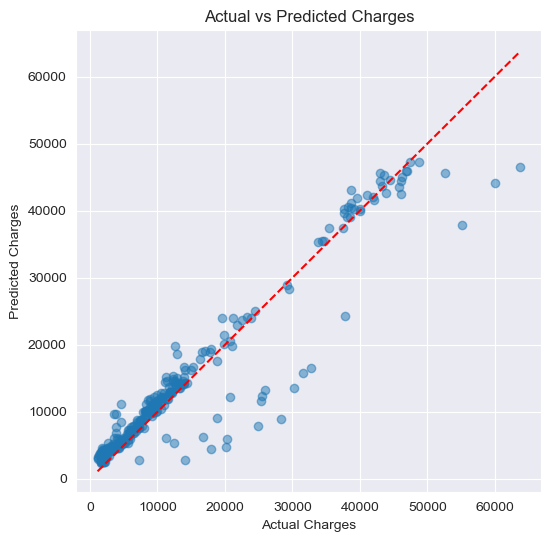

In [44]:
import matplotlib.pyplot as plt

y_pred = xgb.predict(xtest)

plt.figure(figsize=(6,6))
plt.scatter(ytest, y_pred, alpha=0.5)
plt.plot([ytest.min(), ytest.max()],
         [ytest.min(), ytest.max()],
         'r--')  # garis diagonal
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Charges")
plt.show()

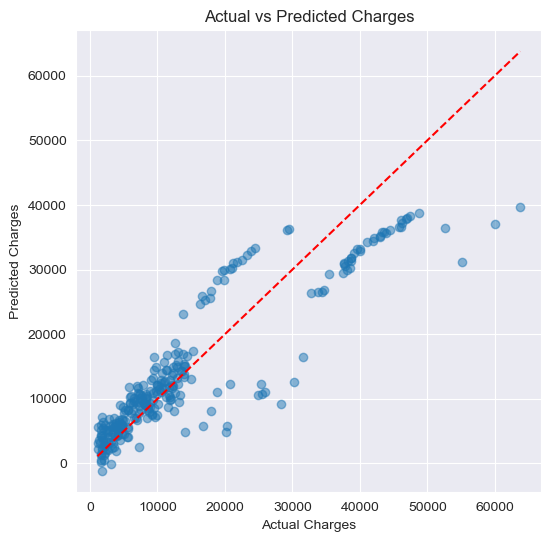

In [46]:
import matplotlib.pyplot as plt

y_pred = lr.predict(xtest)

plt.figure(figsize=(6,6))
plt.scatter(ytest, y_pred, alpha=0.5)
plt.plot([ytest.min(), ytest.max()],
         [ytest.min(), ytest.max()],
         'r--')  # garis diagonal
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Charges")
plt.show()